# Assignment 6: <h1><center> HIỆU CHỈNH CAMERA SỬ DỤNG OPENCV (CAMERA CALIBRATION)</center></h1>

# 1. Sử dụng ảnh bàn cờ để xác định tham số camera

### Tập ảnh bàn cờ khi dùng để xác định các thông số camera
#### - Thông số biết trước: kích thước bàn cờ: 12x8
#### - Tổng số ảnh: 14


In [1]:
# Các thư viện cần thiết
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import math

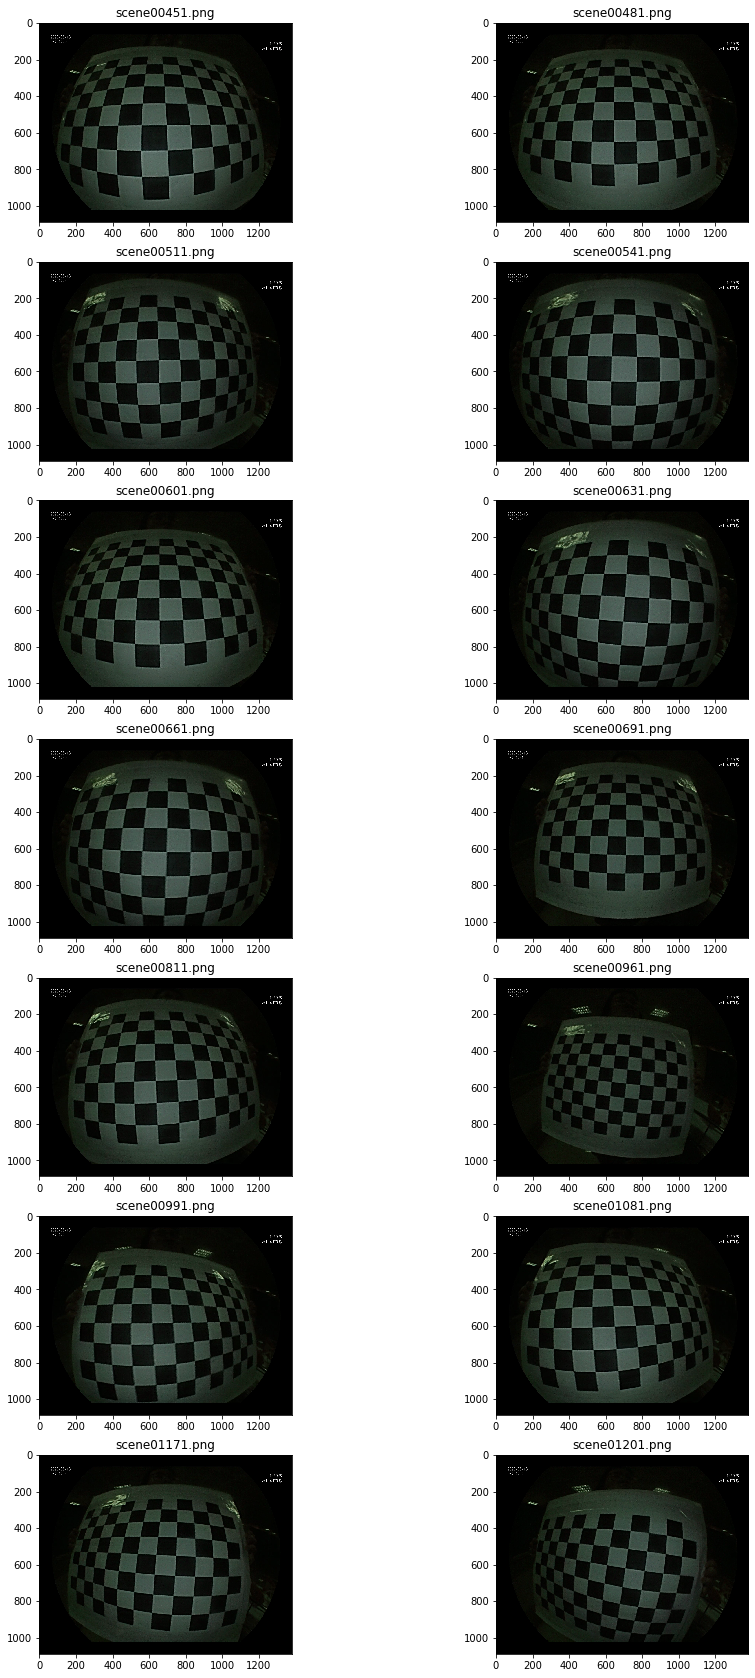

In [2]:
## Đọc ảnh bàn cờ
# UPDATE: Change data path 'data/chessboard' -> 'chessboard'
images=glob.glob('chessboard/*.png')
column=2
row=int(math.ceil(len(images)/column))
column, row
plt.figure(figsize=(15,30))
for i,fname in enumerate(images):
    img=cv2.imread(fname)
    plt.subplot(row,column,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(fname))
plt.show()    

In [3]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01) # điều kiện dừng thuât toán sau số lẩn lặp tối đa hoặc mức độ hội tụ của t toán đạt được

In [4]:
# chessboard dimension (12 x 8) however we need objpoints and imgpoints to have same number of entries and of same size
# Kích thước của bàn cờ (12x8) tuy nhiên chúng ta cần objpoints và impoints có cùng số phần tử và cùng kích thước
cbrow = 11
cbcolumn = 7

In [5]:
# Chuẩn bị object points giống như: (0,0,0), (1,0,0), ...., (10,6,0). Tọa độ Z = 0 
objp = np.zeros((cbrow*cbcolumn, 3), np.float32)
objp[:, :2] = np.mgrid[0:cbrow, 0:cbcolumn].T.reshape(-1, 2)

In [6]:
# Mảng đề lưu object points và image points từ toàn bộ các ảnh đảm bảo 2 mảng này có cùng kích thước
objpoints = []  # lưu trữ tọa độ 3d trong không gian thế giới thực (3d point in real world space)
imgpoints = []   # Lưu tọa độ 2D trên ảnh (2d point in image plane)

In [7]:
# Lấy toàn bộ ảnh bàn cờ và phát hiện các điểm góc trên từng ảnh
# Ghép tương ứng tọa độ 2D phát hiện được và tọa độ 3D
# Các hàm sử dụng: 
#                 findChessboardCorners: tìm các góc bên trong bàn cờ
#                 cornerSubPix: hiệu chỉnh để tăng độ chính xác của góc
# https://docs.opencv.org/3.4.16/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a
# https://docs.opencv.org/3.4.16/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e

# UPDATE: Change data path 'data/chessboard' -> 'chessboard'
images = glob.glob('chessboard/*.png')
i = 0
for fname in images:
    i = i + 1
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Tìm góc của bàn cờ (find the chessboard corners)
    ret, corners = cv2.findChessboardCorners(gray, (11, 7), flags=cv2.CALIB_CB_FILTER_QUADS + cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK)
    
    # Nếu tìm thấy, thêm vào các điểm của đối tượng, điểm của ảnh (sau khi tinh chỉnh) (if found, add object points, image points (after refining them))
    if ret == True:
        corners2 = cv2.cornerSubPix(
            gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)
        objpoints.append(objp)
        
        # Vẽ và hiển thị các góc (Draw and display the corners)
        img = cv2.drawChessboardCorners(img, (cbrow, cbcolumn), corners2, ret)
        cv2.imshow('Image', img)
        #cv2.waitKey(0)
    else:
        print(f"Cannot find the chessboard corners for {fname}. Continue..")


cv2.destroyAllWindows()


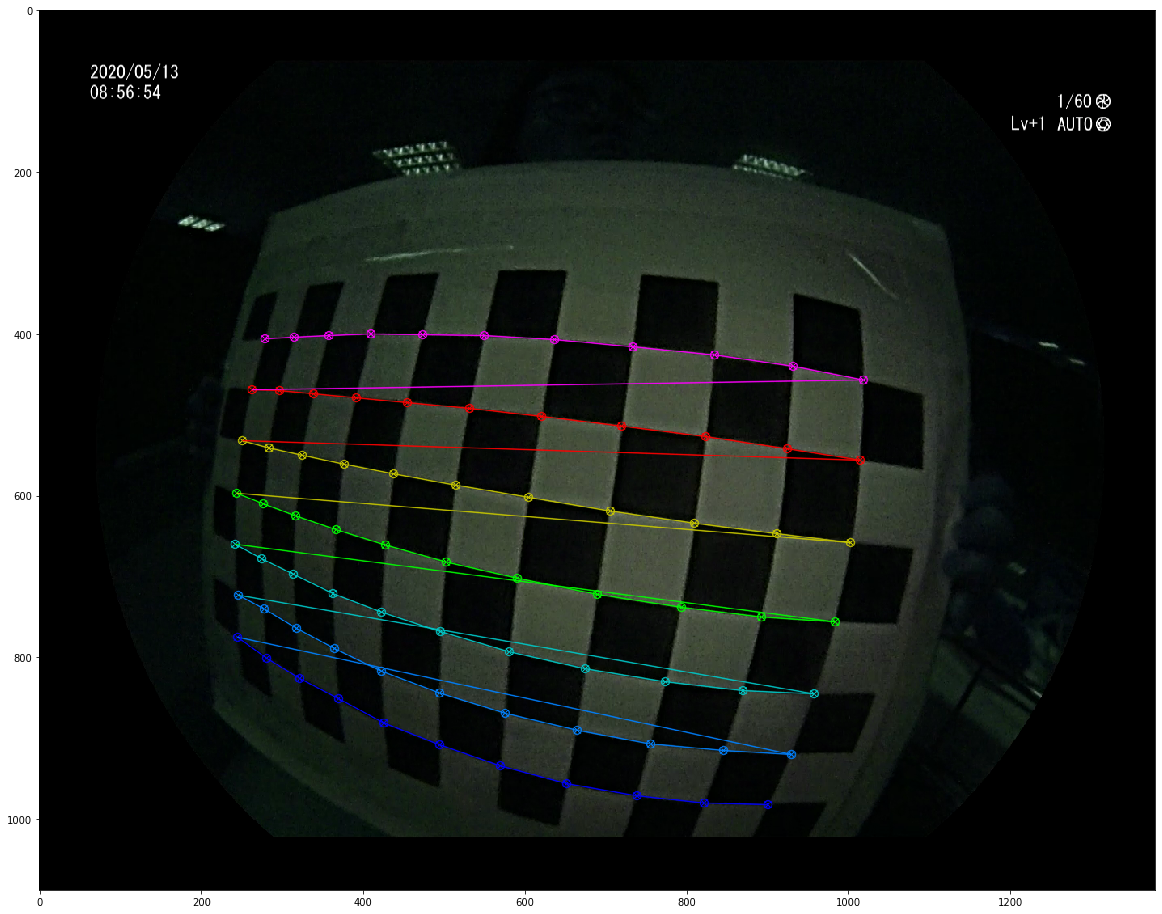

In [8]:
## VD 1 ảnh với các góc được tìm thấy
# Các góc được nối với nhau theo thứ tự trong mang impoints, tương ứng với thứ tự các điểm 3D được lưu trong objpoint

plt.figure(figsize=(20,20))
plt.imshow(img)
plt.show()

In [9]:
# Tìm camera metrix
##### Hiệu chỉnh (CALIBRATION) ######
# https://docs.opencv.org/3.4.16/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d

# mtx: camera metrix (camera intrinsic matrix  )
# dist: distorsion coefficients 
# rvecs: Output vector of rotation vectors (Rodrigues ) estimated for each pattern view
# tvecs : Output vector of translation vectors estimated for each pattern view

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None, flags=cv2.CALIB_RATIONAL_MODEL) 
dist = np.array(dist)

In [10]:
# distorsion coefficients 
dist

array([[-1.66079479e+00,  4.99007574e+00, -9.70243660e-04,
        -1.09751753e-03,  7.18904706e-01, -1.27629025e+00,
         4.36268275e+00,  2.60431243e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]])

In [11]:
# camera intrinsic metrix
mtx

array([[573.09448737,   0.        , 679.10836389],
       [  0.        , 574.472032  , 562.37558912],
       [  0.        ,   0.        ,   1.        ]])

In [12]:
# Output vector of rotation vectors (Rodrigues ) estimated for each pattern view
rvecs[0]
# rotMat, jab = cv2.Rodrigues(rvecs[0])
# rotMat

array([[-0.33162251],
       [-0.07515705],
       [-0.02606981]])

In [13]:
# Vector of translation vectors estimated for each pattern view
tvecs

[array([[-5.01704576],
        [-3.74121533],
        [ 5.0943811 ]]), array([[-5.38720726],
        [-3.99070972],
        [ 5.94718922]]), array([[-4.31376559],
        [-3.09478105],
        [ 4.55569818]]), array([[-5.30381289],
        [-2.42508283],
        [ 4.40775168]]), array([[-5.27213247],
        [-3.84627143],
        [ 6.00099915]]), array([[-5.62982904],
        [-2.60260765],
        [ 5.06856674]]), array([[-4.80153292],
        [-2.65745692],
        [ 4.79509767]]), array([[-4.61111779],
        [-4.32184746],
        [ 6.54179576]]), array([[-4.56178073],
        [-3.69479949],
        [ 5.38134314]]), array([[-5.24057145],
        [-3.32244714],
        [ 8.11006679]]), array([[-3.66163758],
        [-2.62724196],
        [ 5.2939219 ]]), array([[-4.53470046],
        [-3.32877989],
        [ 5.15881605]]), array([[-6.10814519],
        [-3.37575002],
        [ 6.57146404]]), array([[2.59132439],
        [4.88513217],
        [4.61560971]])]

## 2. UNDISTORTION đối với ảnh bàn cờ ban đầu (ảnh dùng để xác định tham số trong và tham số ngoài)

In [14]:
##### UNDISTORTION #####
# UPDATE: Check if result folder exists. If no, make new one. 
output_folder = "chessboard/result"
if not os.path.exists(output_folder):
    os.mkdir(output_folder)
    
img1 = cv2.imread('chessboard/scene00451.png')
h, w = img1.shape[:2]

# Tìm ma trận tham số trong của camera (không biến dạng) từ tham số camera cũ và hệ số biến dạng

# Compute the new camera intrinsic matrix based on the free scaling parameter (alpha)
# alpha: Free scaling parameter between 0 (when all the pixels in the undistorted image are valid) 
# and 1 (when all the source image pixels are retained in the undistorted image)

alpha = 1
newcameramtx, roi = cv2.getOptimalNewCameraMatrix( .....) # YOUR CODE HERE
print("newcameramtx = \n", newcameramtx)

# The original camera intrinsic matrix, distortion coefficients, the computed new camera intrinsic matrix, 
# and newImageSize should be passed to initUndistortRectifyMap to produce the maps for remap.
resultImg = glob.glob('chessboard/*.png')
for rimg in resultImg:
    img = cv2.imread(rimg)
    
    # undistort
    mapx, mapy = cv2.initUndistortRectifyMap(
        mtx, dist, None, newcameramtx, (w, h), cv2.CV_32FC1)  # Computes the undistortion and rectification transformation map. 
            # The function computes the joint undistortion and rectification transformation 
            # and represents the result in the form of maps for remap. 
            # The undistorted image looks like original, as if it is captured with 
            # a camera using the camera matrix =newCameraMatrix and zero distortion.
            
    dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR) #It is the process of taking pixels from one place in the image and locating them in another position in a new image.
    
    # Ghi ảnh kết quả
    path = f"{output_folder}/Calibresult_" + \
        os.path.basename(rimg)
    cv2.imwrite(path, dst)

# Lỗi phép chiếu (re-projection error)
mean_error = 0
for i in range(len(objpoints)): # for each image, len(objpoints) = number of images used for calibration
    imgpoints2, _ = cv2.projectPoints(
        objpoints[i], rvecs[i], tvecs[i], mtx, dist) # chiếu 3D points lên image plan khi đã biết tham số trong và tham số ngoài 
    
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2) # tính sai số (L2) giữa các detected points (corners) và kết quả phép chiếu 
    mean_error += error
print("Mean error", mean_error/len(objpoints))

#cv2.waitKey(0)
#cv2.destroyAllWindows()


newcameramtx = 
 [[194.68891907   0.         638.00695041]
 [  0.         191.03471375 541.50225738]
 [  0.           0.           1.        ]]
Mean error 0.21191726084221282


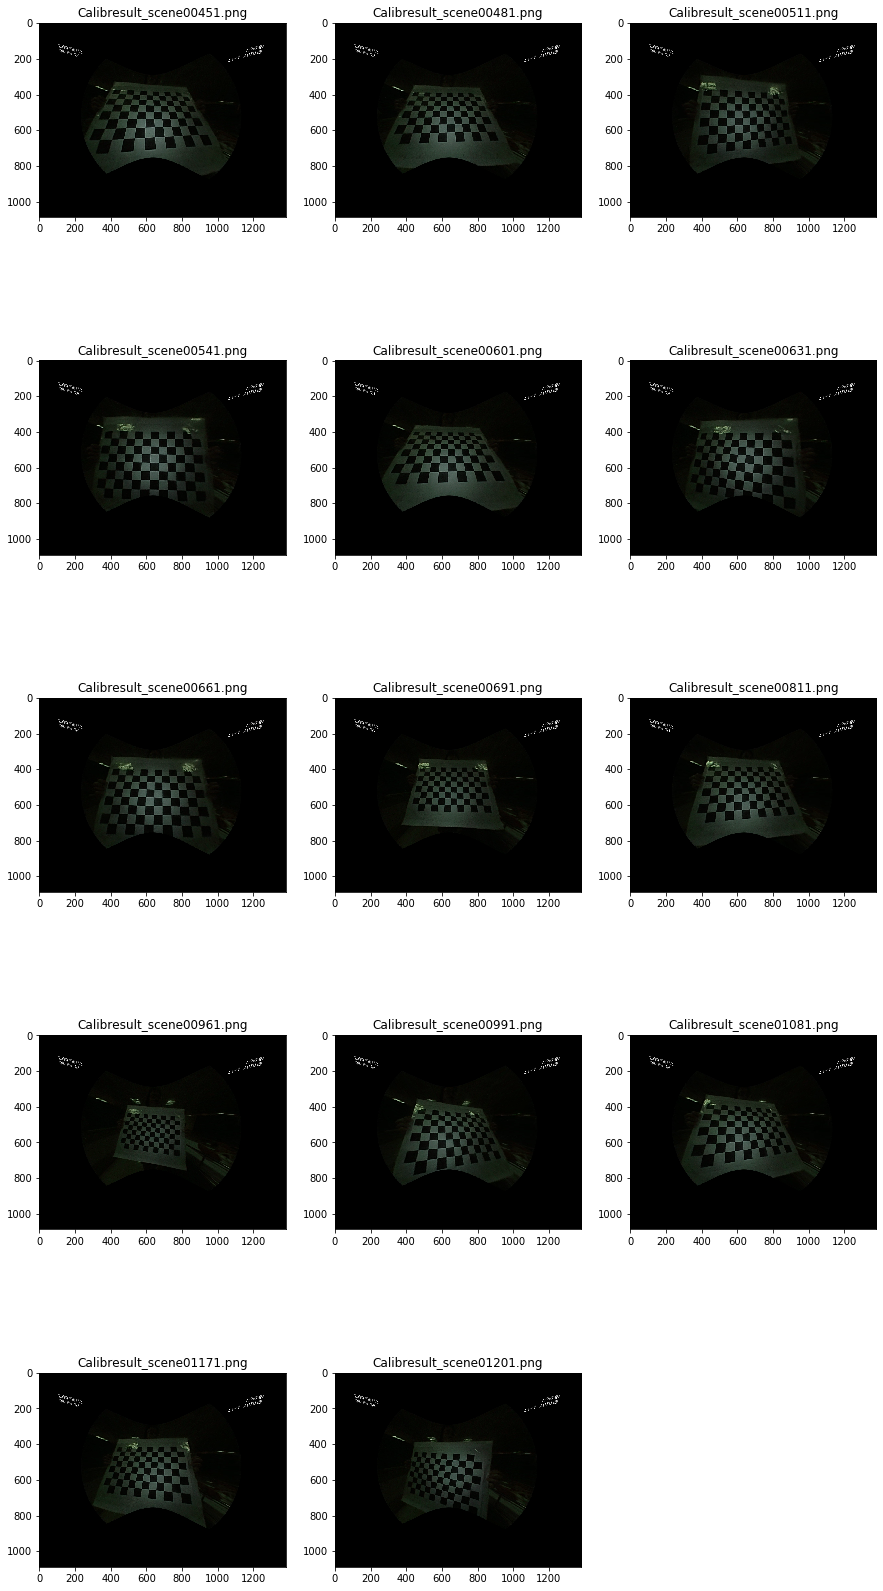

In [15]:
images=glob.glob('chessboard/result/*.png')
column=3
row=int(math.ceil(len(images)/column))
column, row
plt.figure(figsize=(15,30))
for i,fname in enumerate(images):
    img=cv2.imread(fname)
    plt.subplot(row,column,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(fname))
plt.show()

## 3. UNDISTORTION đối với ảnh bàn cờ không dùng trong giai đoạn xác định tham số

In [18]:
##### UNDISTORTION #####
# UPDATE: Check if result folder exists. If no, make new one. 
chessboard_unknow_output_folder = "chessboard_unknow/result"
if not os.path.exists(chessboard_unknow_output_folder):
    os.mkdir(chessboard_unknow_output_folder)
    
img1 = cv2.imread("chessboard_unknow/scene00421.png")
h, w = img1.shape[:2]

# Xác định lại ma trận tham số trong (không distorsion) của camera từ thông số trong của cam và tham số distorsion
############ YOUR CODE HERE ##################
newcameramtx, roi = .......

##############################################
resultImg = glob.glob("chessboard_unknow/*.png")
for rimg in resultImg:
    img = cv2.imread(rimg)
    
    # Khử méo (undistort)
    # ############# YOUR CODE HERE #############

    
    
    #################################################
    
    # Ghi ảnh kết quả
    path = f"{chessboard_unknow_output_folder}/Calibresult_" + \
        os.path.basename(rimg)
    cv2.imwrite(path, dst)

#cv2.waitKey(0)
#cv2.destroyAllWindows()

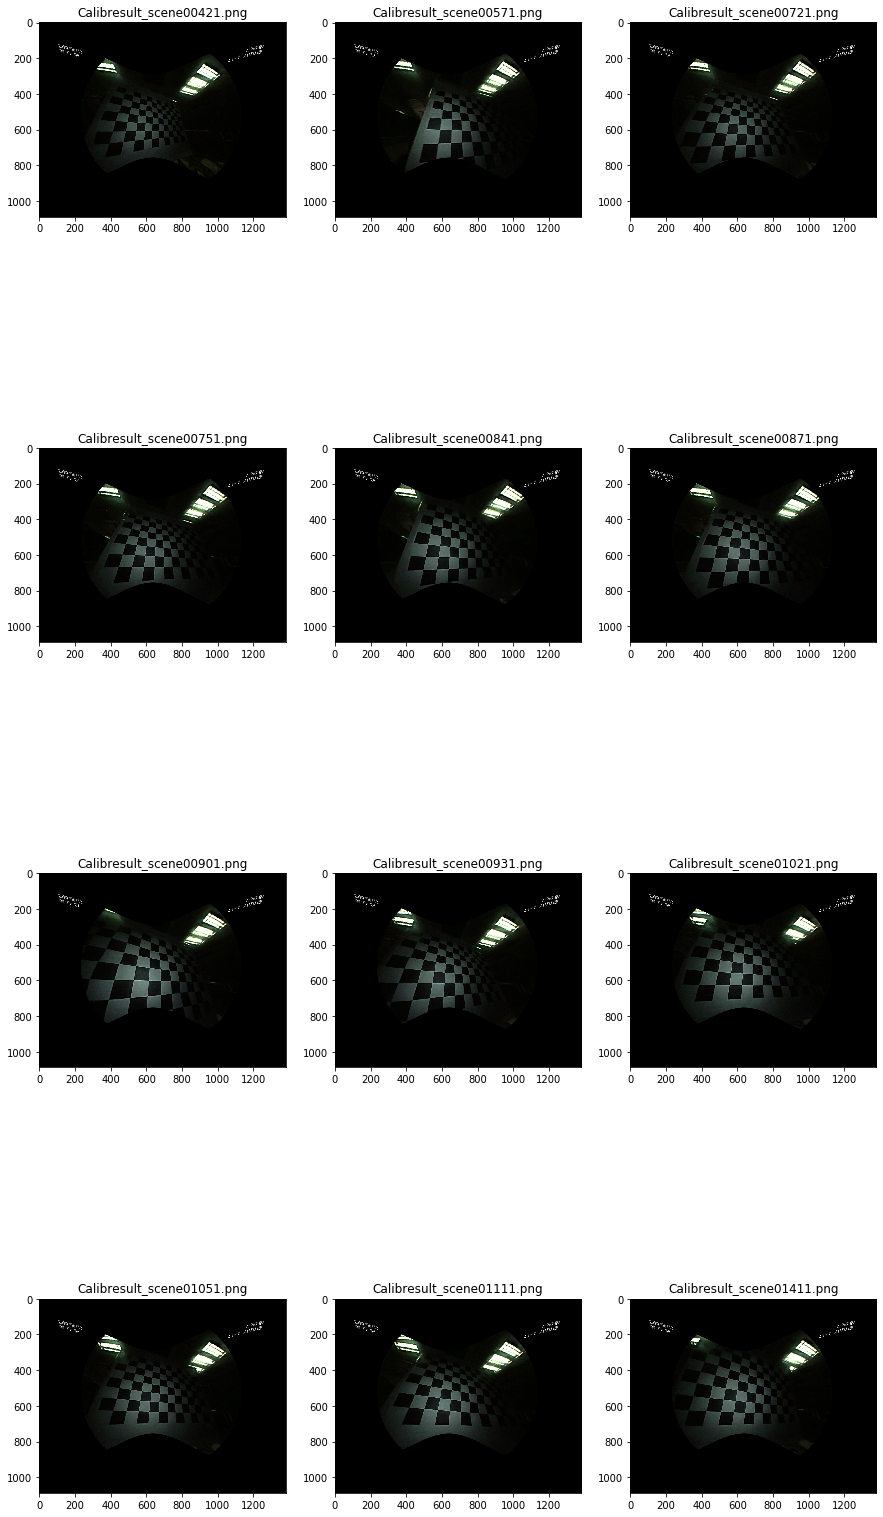

In [19]:
images=glob.glob(f'{chessboard_unknow_output_folder}/*.png')
column=3
row=int(math.ceil(len(images)/column))
column, row
plt.figure(figsize=(15,30))
for i,fname in enumerate(images):
    img=cv2.imread(fname)
    plt.subplot(row,column,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(fname))

plt.show()